# MTA Subway Guide for Immunocompromised Transit Users
### The following notebook details the code run-down delineating traffic levels at different times/days for the NYC subway system. The goal is to provide ranked best travel times (lowest traffic times) by station/line to be used by immunocompromised transit riders to decide when is an opportune time to schedule travel through the city.

The following code:
1. Imports necessary packages    

In [1435]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import urllib.request
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn import datasets

The following code 
1. Imports our data set with the complex ids that will be used to add complex_ids to our MTA turnstiles data set 
2. renames certain columns to match with our MTA turnstiles column names


In [1436]:
complex_ids= pd.read_csv(r'/Users/mehikapatel/Downloads/remote_complex_lookupcsv/body.csv')
complex_ids.rename({'remote':'UNIT', 'division':'DIVISION','line_name':'LINENAME','booth':'C/A', "station": "STATION", "complex_id": "COMPLEX_ID"},inplace=True, axis=1)
complex_ids.head()

,UNIT,C/A,COMPLEX_ID,STATION,LINENAME,DIVISION
0,R001,A060,635.0,WHITEHALL ST,R1,BMT
1,R001,A058,635.0,WHITEHALL ST,R1,BMT
2,R001,R101S,635.0,SOUTH FERRY,R1,IRT
3,R002,A077,628.0,FULTON ST,ACJZ2345,BMT
4,R002,A081,628.0,FULTON ST,ACJZ2345,BMT


The following code:
1. Pulls our MTA turnstiles data from SQL to Python using SQLAlchemy into a datatable called df
2. Run a sample SQL query using SQLAlchemy to obtain 59 ST station's data
3. Gives us a look at some of the first entries in df

In [1437]:
#pull data from SQL to python using SQLAlchemy
engine = create_engine("sqlite:///mta.db")
df = pd.read_sql('SELECT * FROM mta_data;', engine)
#SQLAlchemy Querying 59th ST for initial exploration
FIFTY_NINE_ST_DATA= pd.read_sql("select * FROM mta_data where station='59 ST'",engine)

df.head()
#describe the df
# df.describe()
#info on the df
# df.info()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,03:00:00,REGULAR,7543925,2573549
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,07:00:00,REGULAR,7543931,2573559
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,11:00:00,REGULAR,7543970,2573622
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,15:00:00,REGULAR,7544072,2573700
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,19:00:00,REGULAR,7544219,2573729


The following code:
1. Creates a datetime column in our df set called OBSERVED_TIME

In [1438]:
#create a datetime column
df["OBSERVED_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,OBSERVED_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,03:00:00,REGULAR,7543925,2573549,2021-03-13 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,07:00:00,REGULAR,7543931,2573559,2021-03-13 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,11:00:00,REGULAR,7543970,2573622,2021-03-13 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,15:00:00,REGULAR,7544072,2573700,2021-03-13 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,19:00:00,REGULAR,7544219,2573729,2021-03-13 19:00:00


The following code:
1. Inserts an "ID" column for unique singular identification of a turnstile

In [1439]:
ind_turnstile=df['C/A']+ ' '+df['UNIT']+ ' '+ df['SCP']

df.insert(0, 'ID', ind_turnstile)

df.head()

,ID,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,OBSERVED_TIME
0,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,03:00:00,REGULAR,7543925,2573549,2021-03-13 03:00:00
1,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,07:00:00,REGULAR,7543931,2573559,2021-03-13 07:00:00
2,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,11:00:00,REGULAR,7543970,2573622,2021-03-13 11:00:00
3,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,15:00:00,REGULAR,7544072,2573700,2021-03-13 15:00:00
4,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,19:00:00,REGULAR,7544219,2573729,2021-03-13 19:00:00


The following code:
1. Drops Recovery Audit entries for cleaner dataset, after which there are 206295 rows remaining in the dataframe

In [1440]:
df.drop(df.loc[df['DESC']=='RECOVR AUD'].index, inplace=True)
#206295 ROWS AFTER DROPPING RECOVERY AUDITS
# df.info()

The following code:
1. Creates a new data frame that left merged the MTA turnstiles df with our complex ids data set, which ultimately adds the following variables to our MTA turnstiles:
    * complex_id
    * alternative station name found from complex id data set
    * drops alternative Station and Line Names
    * relabels STATION and LINENAME to original names

Our dataset still has 206295 rows.
 

In [1441]:
#new df with complex ids added to MTA data
Pre_ADA_df=pd.merge(df,complex_ids, on=['UNIT','C/A','DIVISION'], how='left')
#still has 206295 entries
# Pre_ADA_df.info()

#drop new station and line name columns
Pre_ADA_df.drop(['STATION_y', 'LINENAME_y'], axis=1, inplace=True)

#rename columns back to station and linename
Pre_ADA_df.rename({'STATION_x':'STATION','LINENAME_x':'LINENAME'}, axis=1, inplace=True)
# Pre_ADA_df.info()
Pre_ADA_df.head()

,ID,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,OBSERVED_TIME,COMPLEX_ID
0,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,03:00:00,REGULAR,7543925,2573549,2021-03-13 03:00:00,613.0
1,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,07:00:00,REGULAR,7543931,2573559,2021-03-13 07:00:00,613.0
2,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,11:00:00,REGULAR,7543970,2573622,2021-03-13 11:00:00,613.0
3,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,15:00:00,REGULAR,7544072,2573700,2021-03-13 15:00:00,613.0
4,A002 R051 02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,19:00:00,REGULAR,7544219,2573729,2021-03-13 19:00:00,613.0


The following code:
1. Imports the ADA information dataset 
2. Renames Complex ID column to match our other dataframe

In [1442]:
ADA=pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
ADA.rename({'Complex ID': 'COMPLEX_ID', 'Division':'DIVISION'},inplace=True,axis=1)

### WHY ARE THERE SO MANY MORE ROWS EVEN WHEN I DID A LEFT JOIN?!
###### It was found that there was an increase in rows when merging ADA and MTA df so we are investigating in the following code. It seems the ADA dataset uses the same several (51) complex IDs multiple times, which leads to the merge creating a new row for every time a copmlex ID is used in the ADA df. We will sort this by investigating why complex IDs are used multiple times, and by sifting them down to a single complex id/or by combining the information provided.

In [1443]:
ADA.COMPLEX_ID.nunique()
# ADA.info()

#445 unique values versus 496 entries in the dataframe = 51 times certain complex ids are being reused.

445

In [1444]:
# ADA.COMPLEX_ID.describe()

We will drop/change certain values from our ADA set below according to later investigation underneath.

In [1445]:
ADA.drop(162,axis=0, inplace=True)
ADA.drop(468,axis=0, inplace=True)
ADA.drop(469,axis=0, inplace=True)


ADA.drop(412,axis=0, inplace=True)
ADA.drop(171,axis=0, inplace=True)
ADA.drop(17,axis=0, inplace=True)
ADA.drop(103,axis=0, inplace=True)

ADA.drop(466,axis=0, inplace=True)
ADA.drop(470,axis=0, inplace=True)

ADA.drop(274,axis=0, inplace=True)
ADA.drop(116,axis=0, inplace=True)

ADA.drop(335,axis=0, inplace=True)

ADA.drop(91,axis=0, inplace=True)
ADA.drop(23,axis=0, inplace=True)
ADA.drop(26,axis=0, inplace=True)
ADA.drop(149,axis=0, inplace=True)

ADA.drop(166,axis=0, inplace=True)

ADA.drop(435,axis=0, inplace=True)
ADA.drop(111,axis=0, inplace=True)
ADA.drop(72,axis=0, inplace=True)


This finds us the complex IDs used multiple times:

In [1446]:
# ADA.groupby(['COMPLEX_ID']).size().sort_values(ascending=False).head(10)

This creates a list of data frames with the complex ids found to be used multiple times.

In [1447]:
dup_complexes=[611,628, 624,623,610,606,601,602,621,620,617,609,608,607,636,605,635,151,167,603,604,612,622,630,629,627,613,626,625,461,614, 618,615,616,619]


dup_complexes_rows=[]

for num in dup_complexes:
    dup_complexes_rows.append(ADA.loc[ADA['COMPLEX_ID'] == num])

In [1448]:
# Pre_ADA_df.loc[Pre_ADA_df['COMPLEX_ID'] == 617]

In [1449]:
# Pre_ADA_df.loc[Pre_ADA_df['COMPLEX_ID'] == 620].groupby(['STATION']).size()

In [1450]:
# dup_complexes_rows[9]

### Now that we have removed duplicated complex_id information by sifting throguh duplicates, we will also join on division to further nuance the data. Now we can see we have 206295 entries as expected.

The following code:

1. Creates a final working dataset with several variables by combing MTA Data set with ADA dataset via complex ID

**Now our final dataset to work with and further clean will be ADA_df.**



In [1451]:
ADA_df=pd.merge(Pre_ADA_df, ADA, how='left', on=['COMPLEX_ID', 'DIVISION'])

# ADA_df.info()

The following code:
1. Removes unecessary columns. 

In [1452]:
ADA_df.drop(['DESC','Borough','Daytime Routes','Structure', 'Line','GTFS Stop ID'],axis=1,inplace=True)

In [1453]:
# ADA_df.info()

The following code will:
1. Group the rows by turnstile and calculate the actual number of exits and entries.

In [1454]:
ADA_df['ACTUALENTRIES']=ADA_df.groupby(['ID']).ENTRIES.diff()
ADA_df['ACTUALEXITS']=ADA_df.groupby(['ID']).EXITS.diff()

# ADA_df.info()

The following code will:
1. Begin the cleaning process by clearing out entries from hourset 1 of data collection (because these values will not be helpful to us as it is simply the cumulative number of entries and exits).
2. Will absolute value all actual exits and entries values to account for counters that may have counted backwards instead of up.
3. Remove any rows with actual entry and exit values larger than 10,000, as these will likely be entries where the counter reset and are not the actual numbers. 
4. Finally, remove the original Entries and Exits Columns and rename the actual entries and exits to ENTRIES & EXITS respectively.

In [1455]:
#1.
ADA_df.dropna(axis=0,subset=['ACTUALENTRIES'],inplace=True)
ADA_df.dropna(axis=0,subset=['ACTUALEXITS'],inplace=True)
# ADA_df.info()

In [1456]:
#2.
ADA_df.ACTUALENTRIES=ADA_df.ACTUALENTRIES.abs()
ADA_df.ACTUALEXITS=ADA_df.ACTUALEXITS.abs()
# ADA_df.ACTUALEXITS.describe()


In [1457]:
#3.
ADA_df.drop(ADA_df[ADA_df.ACTUALENTRIES >1007].index, inplace=True)
ADA_df.drop(ADA_df[ADA_df.ACTUALEXITS >2225].index, inplace=True)

The following comments show code used to sort through high values to check for counter reset to set above drop value conditionals.

In [1458]:
# ADA_df_TESTER=ADA_df.copy()

# ADA_df_TESTER.drop(ADA_df_TESTER[ADA_df_TESTER.ACTUALENTRIES >1007].index, inplace=True)
# ADA_df_TESTER.drop(ADA_df_TESTER[ADA_df_TESTER.ACTUALEXITS >2225].index, inplace=True)
# ADA_df_TESTER.ACTUALEXITS.describe()
# # ADA_df_TESTER.info()
# # df.drop(df[df.score < 50].index, inplace=True)

In [1459]:
#4. 
ADA_df.drop(['ENTRIES'],axis=1,inplace=True)
ADA_df.drop(['EXITS'],axis=1,inplace=True)

In [1460]:
ADA_df.rename({"ACTUALENTRIES":'ENTRIES',"ACTUALEXITS":"EXITS"},axis=1, inplace=True)
# ADA_df.info()

## Now analysis and plotting

The following code:
1. Creates a new column called "ACTIVITY" that is a sum of entries and exits as a metric for general traffic over time period in that area. 
2. Runs an initial analysis on 59 ST station activity data for week one.  (This will result in guidelines for what time is best to travel through this station.
3. Plots the data points for 59 ST Data.


In [1479]:
#1.
ADA_df['ACTIVITY']= ADA_df.ENTRIES + ADA_df.EXITS

In [1506]:
#create a df for just 59 ST station data
station_59_st= ADA_df[ADA_df['STATION']=='59 ST']
# station_59_st=station_59_st[station_59_st['DATE']=='03/15/2021']
# station_59_st.info()

In [1507]:
#2. 
station_59_st[['ENTRIES','EXITS','ACTIVITY']].describe().round()

,ENTRIES,EXITS,ACTIVITY
count,2209.0,2209.0,2209.0
mean,56.0,65.0,121.0
std,77.0,82.0,123.0
min,0.0,0.0,0.0
25%,3.0,9.0,21.0
50%,25.0,35.0,83.0
75%,78.0,96.0,190.0
max,713.0,695.0,791.0


As we can see from the above analysis on numbers, the average number of transit riders on in a four hour period in the 59 ST Station is 121. Now we will see what the lowest activity traffic hours are for this station by grouping by time.


In [1508]:
station_59_st.groupby(station_59_st.OBSERVED_TIME.dt.hour).mean().round().sort_values(by='ACTIVITY')

,COMPLEX_ID,Station ID,GTFS Latitude,GTFS Longitude,ADA,ENTRIES,EXITS,ACTIVITY
OBSERVED_TIME,,,,,,,,
4,479.0,239.0,41.0,-74.0,0.0,4.0,6.0,10.0
7,489.0,238.0,41.0,-74.0,0.0,9.0,14.0,22.0
0,476.0,240.0,41.0,-74.0,0.0,32.0,26.0,58.0
23,489.0,238.0,41.0,-74.0,0.0,37.0,32.0,69.0
9,613.0,400.0,41.0,-74.0,0.0,10.0,71.0,81.0
11,489.0,238.0,41.0,-74.0,0.0,35.0,64.0,99.0
8,489.0,238.0,41.0,-74.0,0.0,33.0,67.0,100.0
15,489.0,238.0,41.0,-74.0,0.0,56.0,79.0,136.0
19,489.0,238.0,41.0,-74.0,0.0,79.0,75.0,154.0


The above lists in order the lowest traffic four hour period (starting time indicated by hour number under OBSERVED_TIME column) to the highest traffic periods. A client may observe such indicators by station to plan how they might travel depending on traffic levels through the day. 

In [1509]:
means_59_st=station_59_st.groupby(station_59_st.OBSERVED_TIME.dt.hour).mean().round().reset_index()

In [1521]:
means_59_st.sort_values(by='ACTIVITY')

# plt.savefig("59_ST_Chart.png")

<Figure size 432x288 with 0 Axes>

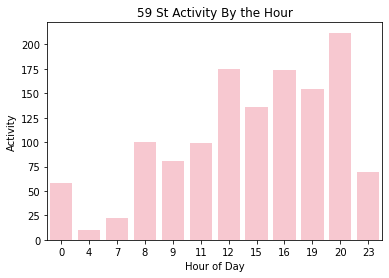

In [1519]:
sns.barplot(x = means_59_st.OBSERVED_TIME,
            y=means_59_st.ACTIVITY, 
            color="pink").set(title="59 St Activity By the Hour", xlabel="Hour of Day", ylabel="Activity")

# plt.savefig("59_ST.png")